<a href="https://colab.research.google.com/github/dj311/uob-summer-project/blob/master/code/ML-adj-matrix-conv-neural-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for training and testing a convolutional neural network model using an adjacency matrix represention of the buffer overflow datapoints in an AST format. 

First, the data is padded with zeros in a standardized format - from the right and down.

Next, we incorporate random padding on the matrices in the testing dataset. 

Then, we randomly pad both the training and testing dataset.

Finally, we train the model on randomly padded data and test on standardized padded data. 

# Colab Setup

In [1]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle
!mkdir -p /project/code
!mkdir -p /project/images
%cd /project/code

--2019-08-23 09:10:26--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-08-23 09:10:26--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   103MB/s    in 13s     

2019-08-23 09:10:39 (99.7 MB/s) - ‘adj.pickle’ saved [1320521199/13205211

In [2]:
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-random-padding.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-random-padding.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary-training-history.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary-training-history.pickle

--2019-08-23 09:10:45--  https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-random-padding.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adjacency-matrix-model-random-padding.pickle [following]
--2019-08-23 09:10:45--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adjacency-matrix-model-random-padding.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71124407 (68M) [application/octet-stream]
Saving to: ‘adjacency-matrix-model-random-padding.pickle’

adjacency-matrix-mo 1

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [3]:
!pip install sklearn

In [4]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split


run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [0]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [0]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [0]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'matrix'})

In [0]:
adj_orig_df = pd.merge(labels, adj, on='testcase_ID')

In [0]:
adj_orig_df = adj_orig_df[['testcase_ID', 'matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [0]:
adj_orig_df['matrix_size'] = adj_orig_df.matrix.apply(lambda x: x.shape[0])

In [13]:
adj_orig_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [14]:
matrix_size = 614
adj_orig_df = adj_orig_df[adj_orig_df['matrix_size'] <= matrix_size]
len(adj_orig_df)

16128

In [0]:
adj_df = adj_orig_df.copy()

In [0]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['matrix'] = adj_df['matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, matrix_size))

In [0]:
testcase_ids = adj_df['testcase_ID'].values
adjacency_matrices = adj_df['matrix'].values
labels = adj_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, labels, batch_size):
        self.sparse_matrices = sparse_matrices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense, np.array(batch_labels)

Finally, we generate the train and test splits:

Load in out pre-generated training and test sets from the graph2vec dataset. We use the indices from these to extract the same set split in our adjacency dataset.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(adjacency_matrices, labels, test_size=0.2, random_state = 0)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [22]:
batch_size = 96
epochs = 5
num_samples = len(labels)

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 16128, (614, 614), (96, 614, 614), 168, (2, 2), 1)

In [0]:
model = Sequential()

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(kernel_size, padding='same'))

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dropout(0.8))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [0]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/adj-architecture-cnn.svg', 'wb') as f:
    f.write(model_diagram)

#SVG(model_diagram)

In [0]:
training_batch_generator = SparseToDenseGenerator(x_train, y_train, batch_size)
val_batch_generator = SparseToDenseGenerator(x_test, y_test, batch_size)

history = model.fit_generator(
    generator=training_batch_generator,
    validation_data=val_batch_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

In [0]:
 import pickle

In [0]:
with open('../data/adjacency-matrix-model-binary.pickle','wb') as f:
    pickle.dump(model,f)

In [0]:
with open('../data/adjacency-matrix-model-binary-training-history.pickle','wb') as f:
    pickle.dump(history,f)

# Evaluation

In [23]:
model = None
with open('../data/adjacency-matrix-model-binary.pickle','rb') as f:
    model = pickle.load(f)

history = None
with open('../data/adjacency-matrix-model-binary-training-history.pickle','rb') as f:
    history = pickle.load(f)

W0823 09:11:16.330413 140239476873088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 09:11:16.390877 140239476873088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 09:11:16.452249 140239476873088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0823 09:11:16.544923 140239476873088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 09:11:16.546746 140239476873088 deprecation_wrap

In [24]:
test_batch_generator = SparseToDenseGenerator(x_test, y_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[0.11802771000188104, 0.9404835700619243]

# Visualisations

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, batch_size):
        self.sparse_matrices = sparse_matrices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(x_test, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

In [0]:
import numpy as np

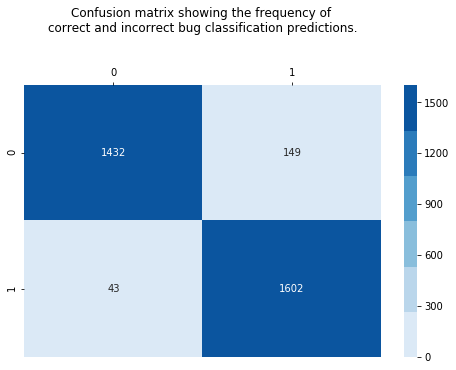

In [29]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
with open('../data/cnn-adj-y-test','wb') as f:
    pickle.dump(y_test, f)

with open('../data/cnn-adj-y-predict','wb') as f:
    pickle.dump(y_predict, f)

In [0]:
from sklearn.metrics import  auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_predict)
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

In [0]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(y_test, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, np.rint(y_predict))
mcc = matthews_corrcoef(y_test, np.rint(y_predict))

In [33]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.951
ROC AUC: 0.940
MCC: 0.883
F1: 0.943


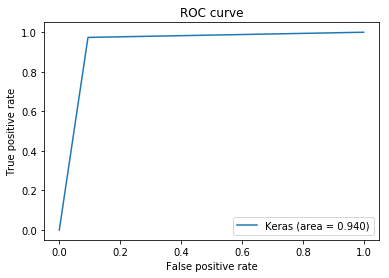

In [34]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [36]:
fpr_nn, fnr_nn

(0.08509423186750428, 0.029152542372881354)

## Random Padding (translational invariance)

Preprocess Dataset

In [0]:
import random

In [0]:
def random_padder(matrix, target_rows, target_columns):
    '''
    Randomly pads matrix with zeros to the desired size
    '''
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    rand = random.randint(matrix.shape[0],matrix_size)
    
    tl_row_corrector = csr_matrix((rand-rows, rows))
    tl_col_corrector = csr_matrix((rand, rand-columns))
    
    tl_matrix = vstack([tl_row_corrector, matrix])
    tl_matrix = hstack([tl_col_corrector, tl_matrix])
    
    rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
    br_row_corrector = csr_matrix((target_rows-rows, rows))
    br_col_corrector = csr_matrix((target_columns, target_columns-columns))

    br_matrix = vstack([tl_matrix, br_row_corrector])
    br_matrix = hstack([br_matrix, br_col_corrector])

    br_matrix = br_matrix.astype(np.int)
    
    return br_matrix

In [0]:
rand_adj_df = adj_orig_df.copy()

In [0]:
rand_adj_df['matrix'] = rand_adj_df['matrix'].apply(lambda m: random_padder(m, matrix_size, matrix_size))

In [0]:
testcase_ids_rand = rand_adj_df['testcase_ID'].values
adjacency_matrices_rand = rand_adj_df['matrix'].values
labels_rand = rand_adj_df['bug'].values

In [43]:
rand_adj_df.matrix.iloc[5].toarray().sum()

778

In [0]:
x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(adjacency_matrices_rand, labels_rand, test_size=0.2, random_state = 0)

Training on standard padded, testing on randomly padded:

In [45]:
test_batch_generator_rand = SparseToDenseGenerator(x_test_rand, y_test_rand, batch_size)

model.evaluate_generator(
    generator=test_batch_generator_rand,
)

[3.4038723821752352, 0.5412275242051646]

58.5% accuracy

Visualisations:

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(x_test_rand, batch_size)
y_predict_rand = model.predict_generator(predict_batch_generator)

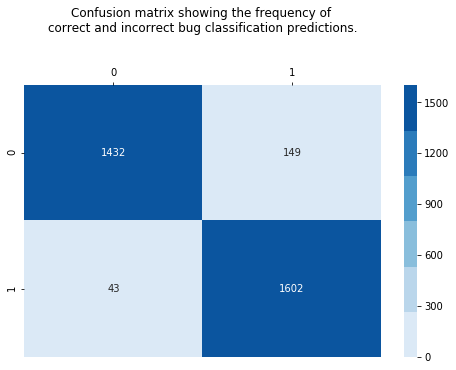

In [47]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test_rand, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_rand.astype(int), y_predict_rand)
precision, recall, thresholds = precision_recall_curve(y_test_rand.astype(int), y_predict_rand)

In [49]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(y_test_rand.astype(int), y_predict_rand))
pr_auc = auc(recall, precision)
f1 = f1_score(y_test_rand.astype(int), np.rint(y_predict_rand))
mcc = matthews_corrcoef(y_test_rand.astype(int), np.rint(y_predict_rand))

print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.951
ROC AUC: 0.940
MCC: 0.883
F1: 0.943


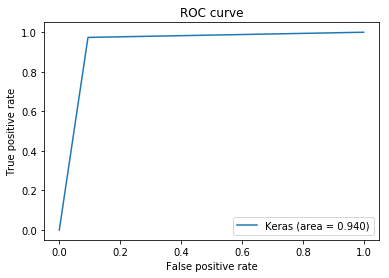

In [50]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test_rand.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [52]:
fpr_nn, fnr_nn

(0.08509423186750428, 0.029152542372881354)

58% accuracy with 3x as more false negatives as there are false positives so our neural network is not learning what we had originally assumed.

Now we will use random padding for both training and testing:

In [53]:
model_rand = Sequential()

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Flatten())

model_rand.add(Dense(units=32, activation='relu'))
model_rand.add(Dense(units=32, activation='relu'))
model_rand.add(Dense(units=32, activation='relu'))

model_rand.add(Dropout(0.8))

model_rand.add(Dense(units=1, activation='sigmoid'))

model_rand.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model_rand.summary()

W0823 09:29:06.815197 140239476873088 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 613, 613, 32)      160       
_________________________________________________________________
activation_1 (Activation)    (None, 613, 613, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 307, 307, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 306, 306, 32)      4128      
_________________________________________________________________
activation_2 (Activation)    (None, 306, 306, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 153, 153, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 152, 152, 32)      4128      
__________

In [54]:
training_batch_generator_rand = SparseToDenseGenerator(x_train_rand, y_train_rand, batch_size)
val_batch_generator_rand = SparseToDenseGenerator(x_test_rand, y_test_rand, batch_size)

history_rand = model_rand.fit_generator(
    generator=training_batch_generator_rand,
    validation_data=val_batch_generator_rand,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 3066s 18s/step - loss: 0.6879 - acc: 0.5400 - val_loss: 0.6663 - val_acc: 0.5839
Epoch 2/5
168/168 [==============================] - 3104s 18s/step - loss: 0.5988 - acc: 0.6654 - val_loss: 0.4495 - val_acc: 0.7877
Epoch 3/5
168/168 [==============================] - 3188s 19s/step - loss: 0.3143 - acc: 0.8469 - val_loss: 0.2622 - val_acc: 0.8935
Epoch 4/5
168/168 [==============================] - 3291s 20s/step - loss: 0.1806 - acc: 0.9206 - val_loss: 0.2439 - val_acc: 0.9171
Epoch 5/5
168/168 [==============================] - 3168s 19s/step - loss: 0.1321 - acc: 0.9552 - val_loss: 0.2730 - val_acc: 0.9136


In [0]:
with open('../data/adjacency-matrix-model-random-padding.pickle','wb') as f:
    pickle.dump(model_rand,f)

with open('../data/adjacency-matrix-model-random-training-history.pickle','wb') as f:
    pickle.dump(history_rand,f) ### DAN: rerun this as I first ran this with a typo

In [0]:
model_rand = None
with open('../data/adjacency-matrix-model-random-padding.pickle','rb') as f:
    model_rand = pickle.load(f)

In [57]:
test_batch_generator_rand = SparseToDenseGenerator(x_test_rand, y_test_rand, batch_size)

model_rand.evaluate_generator(
    generator=test_batch_generator_rand,
)

[0.28160001541691687, 0.9187848733510575]

94.3% accuracy

Visualisations:

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(x_test_rand, batch_size)
y_predict_rand = model_rand.predict_generator(predict_batch_generator_rand)

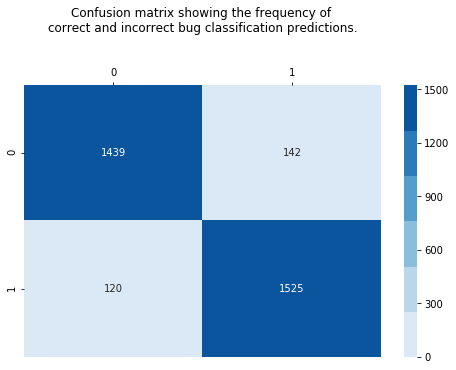

In [59]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test_rand, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_rand.astype(int), y_predict_rand)
precision, recall, thresholds = precision_recall_curve(y_test_rand.astype(int), y_predict_rand)

In [61]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(y_test_rand.astype(int), y_predict_rand)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test_rand.astype(int), np.rint(y_predict_rand))
mcc = matthews_corrcoef(y_test_rand.astype(int), np.rint(y_predict_rand))

print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.975
ROC AUC: 0.973
MCC: 0.838
F1: 0.921


In [0]:
with open('../data/cnn-adj-rand-y-test','wb') as f:
    pickle.dump(y_test_rand.astype(int), f)

with open('../data/cnn-adj-rand-y-predict','wb') as f:
   pickle.dump(y_predict_rand,f)

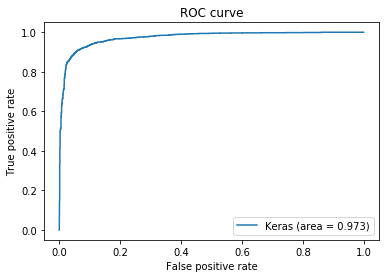

In [63]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test_rand.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

Now testing the model on standard padded matrices when trained on random padding:

In [65]:
test_batch_generator = SparseToDenseGenerator(x_test, y_test, batch_size)

model_rand.evaluate_generator(
    generator=test_batch_generator,
)

[0.49029891437724443, 0.8902665849287763]

90.7% accuracy